In [1]:
# Install the pycoco library as it is not part of the Kaggle environment
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-saho3asg
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-saho3asg
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=272558 sha256=9f5985a4129c20c11ee09ab133f0b7e7ef4528b10d443218cfe41223f3f46efb
  Stored in directory: /tmp/pip-ephem-wheel-cache-fd6ke9qk/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools


In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import random
import cv2
import skimage.io as io
from pycocotools.coco import COCO
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
# Define the image dataset and annotations paths
val_images_path = '../input/food-recognition-challenge/val-v0.4/val/images'
val_anns_path = '../input/food-recognition-challenge/val-v0.4/val/annotations.json'

In [4]:
# Function to load JSON into a COCO api
def getCOCO(anns_path):
    # Initialize the COCO api for instance annotations
    coco = COCO(anns_path)
    
    # Load the categories in a variable
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print number of categories
    nms = [cat['name'] for cat in cats]
    print('\nNumber of COCO categories: {}\n'.format(len(nms)))
    
    # Print number of instances of each category
    df = pd.DataFrame(columns=['Categories', 'Count'])
    
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        df.loc[i] = [nms[i]] + [len(imgIds)]
        
    return coco, df

In [5]:
# Load annotations and print metadata of the image set
coco, df = getCOCO(val_anns_path)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!

Number of COCO categories: 273



In [6]:
# Show types of categories and counts
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df.sort_values('Count', ascending=False).reset_index(drop=True))

,Categories,Count
0,water,98
1,bread-white,65
2,salad-leaf-salad-green,64
3,tomato,52
4,butter,47
5,bread-wholemeal,47
6,coffee-with-caffeine,42
7,carrot,39
8,apple,38
9,mixed-vegetables,34


# Reference Sample for Generator

https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-2-of-2-c0d1f593096a

In [7]:
def filterImgs(coco, classes):    
    images = []
    if classes!=None:
        # Iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images

In [8]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  

In [9]:
def imgGenerator(coco, img_path, classes=None, input_image_size=(224, 224), batch_size=4):
    unique_images = filterImgs(coco, classes)
    dataset_size = len(unique_images)
    print('Number of images: {}'.format(dataset_size))
    
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): # Initially from 0 to batch_size, when c = 0
            imageObj = unique_images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_path, input_image_size)
            
            ### Create Mask ###
            train_mask = getMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(unique_images)
            
        yield img, mask

In [10]:
def visualiseGen(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            ax.title.set_text('Image {}'.format(j))
            fig.add_subplot(ax)        
    
    plt.show()

Number of images: 64


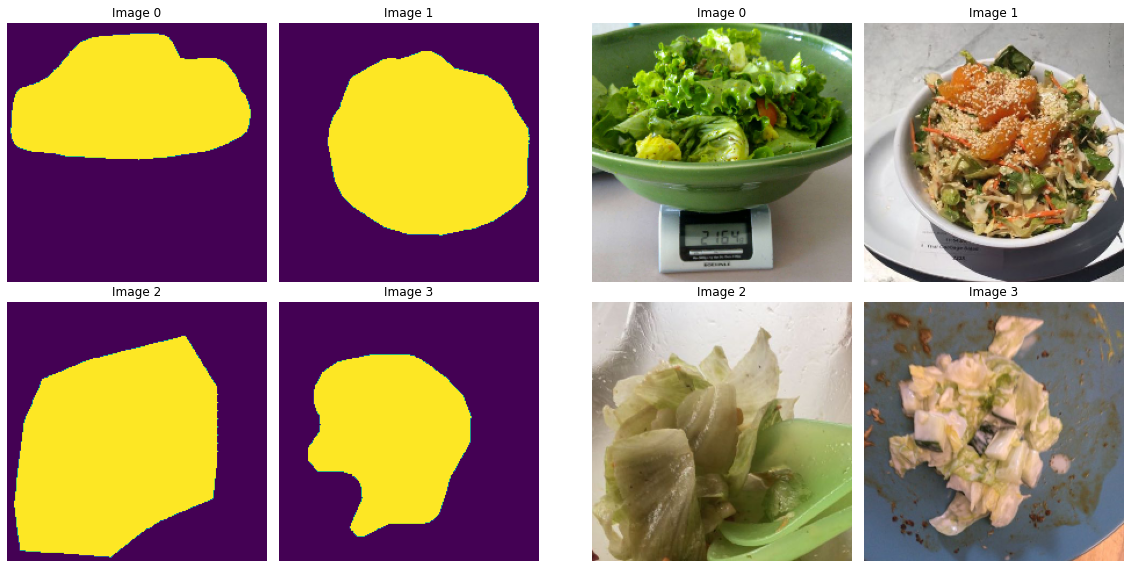

In [11]:
# Preview a sample of the generator with filtered classes
classes = ['salad-leaf-salad-green']
input_image_size = (224, 224)
batch_size = 4

val_gen = imgGenerator(coco, val_images_path, classes, input_image_size, batch_size)
visualiseGen(val_gen)

# Reference Sample for Model

https://towardsdatascience.com/medical-images-segmentation-using-keras-7dc3be5a8524

In [12]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History

In [13]:
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [14]:
def get_unet():
    inputs = Input((224, 224, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [15]:
# Train the model on the image data
model = get_unet()
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
history=model.fit(val_gen, epochs=20, shuffle=True, batch_size=4, steps_per_epoch=16, callbacks=[model_checkpoint])

Epoch 1/20
16/16 [==============================] - 44s 3s/step - loss: -0.4140 - dice_coef: 0.4140
Epoch 2/20
16/16 [==============================] - 42s 3s/step - loss: -0.5063 - dice_coef: 0.5063
Epoch 3/20
16/16 [==============================] - 42s 3s/step - loss: -0.4747 - dice_coef: 0.4747
Epoch 4/20
16/16 [==============================] - 42s 3s/step - loss: -0.5503 - dice_coef: 0.5503
Epoch 5/20
16/16 [==============================] - 42s 3s/step - loss: -0.5514 - dice_coef: 0.5514
Epoch 6/20
16/16 [==============================] - 41s 3s/step - loss: -0.5547 - dice_coef: 0.5547
Epoch 7/20
16/16 [==============================] - 42s 3s/step - loss: -0.5127 - dice_coef: 0.5127
Epoch 8/20
16/16 [==============================] - 41s 3s/step - loss: -0.5105 - dice_coef: 0.5105
Epoch 9/20
16/16 [==============================] - 41s 3s/step - loss: -0.4971 - dice_coef: 0.4971
Epoch 10/20
16/16 [==============================] - 41s 3s/step - loss: -0.5262 - dice_coef: 0.5262

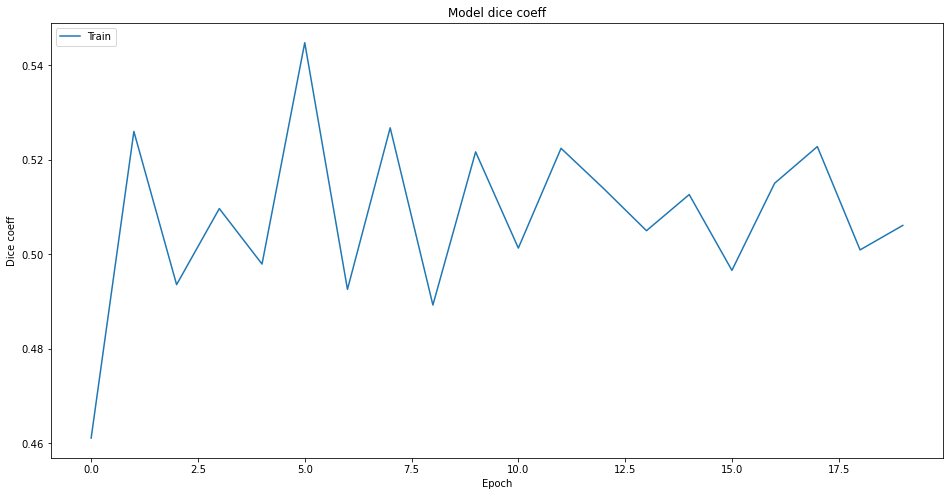

In [16]:
# Plot the error over the epochs
plt.figure(figsize=(16, 8))
plt.plot(history.history['dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()